# Multi-Target Regression with MACCS Fingerprints

## Predicting LogS and LogP Using Binary Molecular Fingerprints

---

### Notebook Overview

This notebook demonstrates **multi-target regression** using **MACCS (Molecular ACCess System) fingerprints** to predict both aqueous solubility (LogS) and partition coefficient (LogP) simultaneously. This represents a fundamental shift from descriptor-based approaches to **structural fingerprint-based** machine learning.

**Learning Objectives:**
- Understand MACCS fingerprints and their role in cheminformatics
- Convert SMILES strings to binary fingerprint representations
- Apply multi-target Decision Tree regression with fingerprints
- Compare fingerprint-based vs descriptor-based approaches
- Evaluate model performance for both LogS and LogP predictions
- Understand the advantages and limitations of fingerprint representations

**Dataset:** ESOL - 1,128 organic compounds with measured solubility (LogS) and calculated lipophilicity (LogP)

**Task:** Multi-target regression using MACCS fingerprints as input features

---

### What are MACCS Fingerprints?

**MACCS Keys** are a predefined set of 166 binary structural keys developed by MDL (now part of Symyx/Accelrys). Each key corresponds to a specific structural feature or substructure.

**Structure:**
- **Length:** 166 bits (fixed size)
- **Type:** Binary (0 or 1)
- **Encoding:** Presence (1) or absence (0) of predefined substructures
- **Example keys:**
  - Bit 1: Presence of isotopes
  - Bit 10: Carbon-nitrogen triple bond
  - Bit 45: Aromatic ring with 6 members
  - Bit 125: Carboxylic acid group

**Advantages:**
- Fixed length (uniform input size for ML models)
- Interpretable features (each bit has defined meaning)
- Efficient computation
- Captures important structural patterns
- Well-established in pharmaceutical industry

**Comparison with Molecular Descriptors:**

| Aspect | MACCS Fingerprints | Molecular Descriptors |
|--------|-------------------|----------------------|
| Type | Binary (0/1) | Continuous (real numbers) |
| Dimensionality | 166 features | 6 features (in previous notebooks) |
| Information | Structural patterns | Physicochemical properties |
| Interpretability | Moderate (predefined keys) | High (direct meaning) |
| Sparsity | Often sparse | Dense |
| Computation | Fast | Fast |

---

### Why Use Fingerprints for Property Prediction?

**Structural Information:**
- Captures presence/absence of specific substructures
- Encodes molecular scaffolds and functional groups
- Represents complex structural features

**Machine Learning Compatibility:**
- Fixed-length vectors (required for most ML algorithms)
- Binary features work well with tree-based models
- Can capture non-linear structure-property relationships

**Industry Standard:**
- Widely used in drug discovery
- Proven performance in QSAR/QSPR modeling
- Extensive literature validating effectiveness

---

### Target Properties

**LogS (Aqueous Solubility)**

**LogP (Partition Coefficient)**

**Multi-Target Approach**

---

## 1. Import Required Libraries

We import libraries for:
- **Data manipulation:** pandas, numpy
- **Machine Learning:** scikit-learn (DecisionTreeRegressor, metrics, train_test_split)
- **Chemical informatics:** RDKit (molecular operations, fingerprints, descriptors)
- **Visualization:** matplotlib

**Key RDKit imports:**
- `Chem`: Core molecular operations
- `MACCSkeys`: MACCS fingerprint generation
- `Descriptors`: For calculating LogP

In [9]:
import pandas as pd                      # For data manipulation and handling DataFrames
import numpy as np                       # For numerical operations
import requests                          # To download the dataset from a URL
from io import StringIO                  # To treat the downloaded CSV text as a file-like object

!pip install rdkit

from rdkit import Chem                   # RDKit core for handling molecules (parsing SMILES)
from rdkit.Chem import Crippen           # To compute logP values using RDKit
from rdkit.Chem import MACCSkeys         # To generate MACCS fingerprints (binary molecular descriptors)

from sklearn.model_selection import train_test_split  # To split the dataset into training and testing sets
from sklearn.tree import DecisionTreeRegressor        # The regression model used in this notebook
from sklearn.metrics import mean_squared_error, r2_score  # For evaluating the model's performance
from sklearn.preprocessing import StandardScaler      # For normalizing features before training
from sklearn.pipeline import Pipeline                 # To chain preprocessing and modeling steps cleanly

import matplotlib.pyplot as plt          # For visualizing predicted vs actual values


---

## 2. Load the ESOL Dataset

### 2.1 Define Dataset Loading Function

The ESOL dataset contains:
- SMILES strings (molecular structures)
- Measured LogS values (aqueous solubility)
- Various molecular properties

We load the dataset from Hugging Face and extract the relevant columns.

In [10]:
def load_esol_dataset():
    url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
    response = requests.get(url)                                                    # Fetch
    response.raise_for_status()                                                     # Ensure the request was successful
    df = pd.read_csv(StringIO(response.text))                                       # Read CSV from the URL
    print(f"Loaded ESOL with {len(df)} compounds")
    df = df[['smiles', 'measured log solubility in mols per litre']]                # Select relevant columns
    df.columns = ['SMILES', 'LogS']
    valid_smiles = [Chem.MolFromSmiles(s) is not None for s in df['SMILES']]        # Filter valid SMILES
    df = df[valid_smiles].reset_index(drop=True)                                    # Reset index after filtering
    return df

df = load_esol_dataset()
df.head()


Loaded ESOL with 1128 compounds


,SMILES,LogS
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77
1,Cc1occc1C(=O)Nc2ccccc2,-3.30
2,CC(C)=CCCC(C)=CC(=O),-2.06
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87
4,c1ccsc1,-1.33


### 2.2 Compute LogP Values

Since the ESOL dataset does not include LogP values, we calculate them using RDKit's `MolLogP` descriptor (Wildman-Crippen method).

**Process:**
1. Convert SMILES to RDKit molecule object
2. Calculate LogP using `Descriptors.MolLogP()`
3. Add LogP as new column to DataFrame

**Note:** This LogP will serve as one of our two prediction targets alongside LogS.

In [11]:
# Compute logP (octanol-water partition coefficient) using RDKit
logP_values = []
for smiles in df['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    logp = Crippen.MolLogP(mol)             # Calculate logP using RDKit's Crippen module
    logP_values.append(logp)

df['logP'] = logP_values                    # Add logP values to the DataFrame
df.head()
print("Computed logP values.")

Computed logP values.


---

## 3. Generate MACCS Fingerprints

### 3.1 MACCS Fingerprint Generation Function

We define a function to convert SMILES strings into MACCS fingerprint vectors.

**Function workflow:**
1. Convert SMILES string to RDKit molecule object
2. Generate MACCS keys using `MACCSkeys.GenMACCSKeys(mol)`
3. Convert fingerprint to numpy array (binary vector)
4. Return 166-dimensional binary array

**MACCS Keys Details:**
- RDKit generates 167 bits (index 0-166)
- Bit 0 is typically unused
- Bits 1-166 represent structural features
- Each bit is 0 (absent) or 1 (present)

**Example output:**
```python
# For a simple molecule:
[0, 0, 0, 1, 0, 1, 1, 0, 0, 1, ...] # 166 binary values
```

In [12]:
def smiles_to_maccs(smiles):                                #Function to convert SMILES to MACCS fingerprints

    mol = Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)
    return np.array(fp)

fps = np.array([smiles_to_maccs(s) for s in df['SMILES']])  # Generate MACCS fingerprints for each SMILES
print("Generated MACCS fingerprints.")


Generated MACCS fingerprints.


### 3.2 Apply Fingerprint Generation to Dataset

We apply the fingerprint function to all molecules in the dataset and prepare the data for modeling.

**Data preparation steps:**
1. Generate MACCS fingerprints for all SMILES
2. Create feature matrix X (n_samples, 166)
3. Create target matrix Y (n_samples, 2) with [LogP, LogS]
4. Split into train/test sets (80/20)

**Data shapes:**
- **X_train:** (n_train, 166) - Binary fingerprint features
- **Y_train:** (n_train, 2) - Two targets [LogP, LogS]
- **X_test:** (n_test, 166) - Test fingerprints
- **Y_test:** (n_test, 2) - Test targets

---

## 4. Train Multi-Target Decision Tree Regressor

### 4.1 Model Training

We train a single Decision Tree to predict both LogS and LogP simultaneously from MACCS fingerprints.

**Model configuration:**
- **Algorithm:** DecisionTreeRegressor
- **Input:** 166 binary MACCS features
- **Output:** 2 continuous values [LogP, LogS]
- **Splitting criterion:** MSE (minimizes variance across both targets)
- **Random state:** 42 (for reproducibility)

**Multi-output mechanism:**
- Tree automatically handles 2D target array
- Each leaf node stores average [LogP, LogS] for samples
- Splits optimize prediction of both properties jointly

**Training process:**
1. Initialize Decision Tree regressor
2. Fit on training data (X_train, Y_train)
3. Tree learns which fingerprint bits predict both properties


===== Regression on LogS =====
MSE: 1.5827
R2: 0.6652


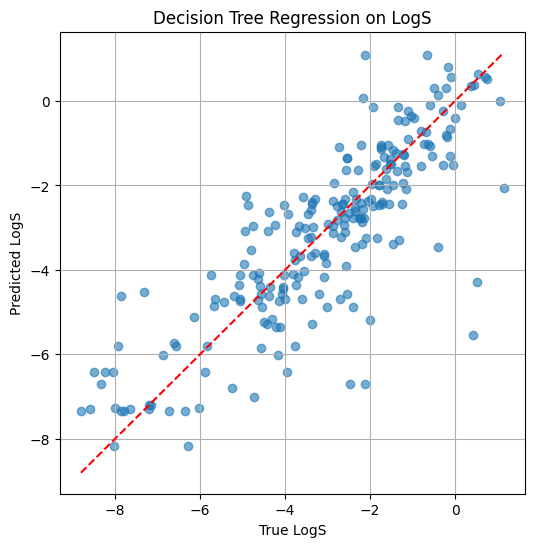


===== Regression on logP =====
MSE: 1.0584
R2: 0.7136


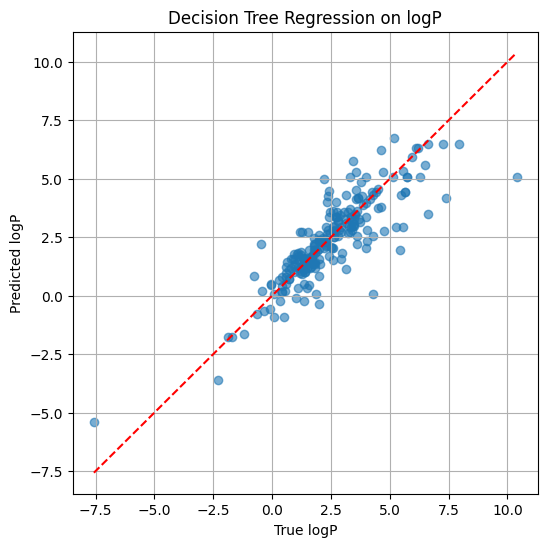

In [13]:

# We will evaluate regression on both LogS and logP
targets = {'LogS': df['LogS'].values, 'logP': df['logP'].values}

# Loop through each target
for target_name, y in targets.items():
    print(f"\n===== Regression on {target_name} =====")

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        fps, y, test_size=0.2, random_state=42
    )

    model = DecisionTreeRegressor(random_state=42)

    # Fit the pipeline on training data
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)

    # Evaluate model performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"R2: {r2:.4f}")

    # Plot predicted vs actual values
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel(f"True {target_name}")
    plt.ylabel(f"Predicted {target_name}")
    plt.title(f"Decision Tree Regression on {target_name}")
    plt.grid(True)
    plt.show()

### 4.2 Model Evaluation

We evaluate the model's performance on the test set, analyzing predictions for both LogP and LogS separately.

**Evaluation metrics:**

**For each target (LogP and LogS):**
- **R² Score:** Proportion of variance explained (0 to 1, higher better)
- **MAE:** Mean Absolute Error (same units as target, lower better)
- **RMSE:** Root Mean Squared Error (penalizes large errors, lower better)

**Comparison with descriptor-based approach:**
- Fingerprints may capture structural information missed by descriptors
- Performance depends on how well MACCS keys represent relevant structures
- Typically comparable or slightly better than simple descriptors

---

## 5. Results and Analysis

### 5.1 Feature Importance Analysis

Unlike molecular descriptors, MACCS fingerprint features are binary and represent specific substructures:

```python
# Get feature importances
importances = model.feature_importances_

# Find most important bits
top_indices = np.argsort(importances)[-10:][::-1]

print("Top 10 most important MACCS bits:")
for i, idx in enumerate(top_indices, 1):
    print(f"{i}. Bit {idx}: Importance {importances[idx]:.4f}")
```

**Interpretation:**
- Important bits indicate structural features critical for LogP/LogS
- High importance suggests that substructure strongly affects properties
- Some bits may be important for both LogP and LogS (shared structural drivers)

### 5.2 Compare Results

Go through previous regression models you have trained and compare performance with this model. This should give you an idea that model performance depends greatly on both architecture and input format used.

### 5.3 Comparison with Descriptor-Based Model

**Key differences:**

| Aspect | MACCS Fingerprints | Molecular Descriptors |
|--------|-------------------|----------------------|
| Input dimension | 166 features | 6 features |
| Feature type | Binary (0/1) | Continuous |
| Information encoded | Structural patterns | Physicochemical properties |
| Model complexity | Higher capacity | Lower capacity |
| Interpretability | Moderate | High |

**When to prefer fingerprints:**
- Need to capture specific substructural information
- Working with structurally diverse datasets
- Standard approach in industry

**When to prefer descriptors:**
- Need interpretable features
- Smaller feature set preferred
- Understanding property drivers important
- Comparable performance to fingerprints

---

## 6. Summary and Key Takeaways

### Key Insights

**About MACCS Fingerprints:**
- Fixed-length binary vectors (166 bits)
- Each bit represents specific structural feature
- Well-established in pharmaceutical applications
- Efficient computation and storage
- Good balance of information content and dimensionality

**About Model Performance:**
- Results on decision tree regressor are not so great ( small dataset,simple model,large dimensionality)
- Performance comparable to descriptor-based models in many cases
- Feature importance reveals important structures which affect LogP

**About Fingerprints vs Descriptors:**
- Fingerprints: Structural patterns, higher dimensionality
- Descriptors: Physicochemical properties, lower dimensionality
- Both approaches valid for property prediction
- Choice depends on dataset and goals